In [23]:
%matplotlib inline
import numpy as np
import struct
import matplotlib.pyplot as plt
import csv
import pandas as pd
from keras import backend  as K
import keras
import tensorflow as tf

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,Conv1D, MaxPooling1D
from keras import optimizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy

In [24]:
data = pd.read_csv('2018-06-06-pdb-intersect-pisces.csv')
#data.len.hist(bins=50)

In [30]:
#data preprocessing, I used sequences with length <= 400, which contains 85% data

#transform raw data into array
#aa_seqs, dssp_seqs = data[['seq', 'sst3']][(data.len<400)].values.T
aa_seqs, dssp_seqs = data[['seq', 'sst8']][(data.len<400)].values.T
aa_seq_array = np.array([[aa_seq[i] for i in range(len(aa_seq))] for aa_seq in aa_seqs])
dssp_seq_array = np.array([[dssp_seq[i] for i in range(len(dssp_seq))] for dssp_seq in dssp_seqs])


#using one-hot-encoding to transform 21 AA and DSSP states to computable equivalent states
one_hot_encoding = Tokenizer()
one_hot_encoding.fit_on_texts(aa_seq_array)
input_data = one_hot_encoding.texts_to_sequences(aa_seq_array)
input_data = sequence.pad_sequences(input_data, maxlen=400, padding='post')
one_hot_decoding = Tokenizer(char_level=True)
one_hot_decoding.fit_on_texts(dssp_seq_array)
target_data = one_hot_decoding.texts_to_sequences(dssp_seq_array)
target_data = sequence.pad_sequences(target_data, maxlen=400, padding='post')
target_data = to_categorical(target_data)
X_train = input_data
y_train = target_data

In [34]:
#model using CNN and LSTM
n_aa = len(one_hot_encoding.word_index) + 1
n_dssp = len(one_hot_decoding.word_index) + 1

input = Input(shape=(400,))
x = Embedding(input_dim=n_aa, output_dim=400, input_length=400)(input)
x = Conv1D(64, 1, activation='relu', strides=1)(x)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_dssp, activation='softmax'))(x)
model = Model(input, y)

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 400, 400)          8800      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 400, 64)           25664     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 400, 128)          66048     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 400, 9)            1161      
Total params: 101,673
Trainable params: 101,673
Non-trainable params: 0
_________________________________________________________________


In [36]:
#history class used to plot accuracy and loss
class LossHistory(keras.callbacks.Callback): 
    def on_train_begin(self, logs={}): 
        self.losses = {'batch':[], 'epoch':[]} 
        self.accuracy = {'batch':[], 'epoch':[]} 
        self.val_loss = {'batch':[], 'epoch':[]} 
        self.val_acc = {'batch':[], 'epoch':[]} 
    def on_batch_end(self, batch, logs={}): 
        self.losses['batch'].append(logs.get('loss')) 
        self.accuracy['batch'].append(logs.get('acc')) 
        self.val_loss['batch'].append(logs.get('val_loss')) 
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}): 
        self.losses['epoch'].append(logs.get('loss')) 
        self.accuracy['epoch'].append(logs.get('acc')) 
        self.val_loss['epoch'].append(logs.get('val_loss')) 
        self.val_acc['epoch'].append(logs.get('val_acc')) 
    def loss_plot(self, loss_type): 
        iters = range(len(self.losses[loss_type])) 
        plt.figure() 
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc') 
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss') 
        if loss_type == 'epoch': 
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc') 
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss') 
        plt.grid(True) 
        plt.xlabel(loss_type) 
        plt.ylabel('acc-loss') 
        plt.legend(loc="upper right") 
        plt.show()

Train on 5484 samples, validate on 2351 samples
Epoch 1/10
5484/5484 [==============================] - 216s 39ms/step - loss: 1.0139 - acc: 0.7348 - val_loss: 1.2976 - val_acc: 0.4740
Epoch 2/10
5484/5484 [==============================] - 203s 37ms/step - loss: 0.5554 - acc: 0.7825 - val_loss: 1.1925 - val_acc: 0.5398
Epoch 3/10
5484/5484 [==============================] - 205s 37ms/step - loss: 0.5055 - acc: 0.8104 - val_loss: 1.1257 - val_acc: 0.5804
Epoch 4/10
5484/5484 [==============================] - 219s 40ms/step - loss: 0.4851 - acc: 0.8209 - val_loss: 1.1044 - val_acc: 0.5882
Epoch 5/10
5484/5484 [==============================] - 214s 39ms/step - loss: 0.4732 - acc: 0.8261 - val_loss: 1.0817 - val_acc: 0.6001
Epoch 6/10
5484/5484 [==============================] - 208s 38ms/step - loss: 0.4662 - acc: 0.8289 - val_loss: 1.0677 - val_acc: 0.6043
Epoch 7/10
5484/5484 [==============================] - 199s 36ms/step - loss: 0.4608 - acc: 0.8308 - val_loss: 1.0574 - val_acc: 

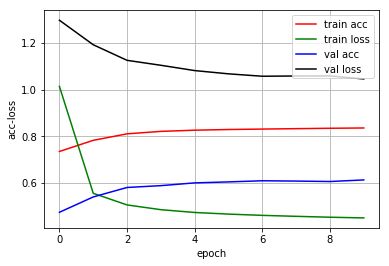

In [37]:
#fit the model
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

history = LossHistory()

model.fit(X_train, y_train, batch_size=128, epochs=10, 
          validation_split=0.3,
          shuffle=True, callbacks=[history], verbose=1)

history.loss_plot('epoch')

In [40]:
#test on a few sequences and reverse to letters to see the prediction
def rev_one_hot(one_hot_seq, code_tab):
    dssp_str = ''
    for i in one_hot_seq:
        i = np.argmax(i)
        if i > 0:
            dssp_str += code_tab[i]
        else:
            break
    return dssp_str

def plot_results(aa, dssp, dssp_pred):
    print("AA sequence: ")
    print(str(aa))
    print("Secondary structure sequence: ")
    print(str(rev_one_hot(dssp, revsere_decoder_index).upper()))
    print("Prediction sequence: ")
    print(str(rev_one_hot(dssp_pred, revsere_decoder_index).upper()))
    print(" ")
    
revsere_decoder_index = {value:key for key,value in one_hot_decoding.word_index.items()}

y_train_pred = model.predict(X_train[:3])

for i in range(N):
    plot_results(aa_seqs[i], y_train[i], y_train_pred[i])

AA sequence: 
NPVVHFFKNIVTPRTPPPSQ
Secondary structure sequence: 
CCCCCBCCCCCCCCCCCCCC
Prediction sequence: 
CCEEEEEEEEECCCCCCCCC
 
AA sequence: 
DLDLEMLAPYIPMDDDFQLR
Secondary structure sequence: 
CCCCCCCCCBCCSCCCEECC
Prediction sequence: 
CCCHHHCCCCCCCCCCHCCC
 
AA sequence: 
EEDPDLKAAIQESLREAEEA
Secondary structure sequence: 
CCCHHHHHHHHHHHHHHHTC
Prediction sequence: 
CCCCCHHHHHHHHHHHCCCC
 
